<a href="https://colab.research.google.com/github/YANI-ALT/FML-GNN_DisagreementProblem/blob/main/DIG_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch torchvision
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-+.html
  Created wheel for torch-scatter: filename=torch_scatter-2.0.9-cp37-cp37m-linux_x86_64.whl size=274491 sha256=8bb3a9ec178484ef2c4b6f42da6e889a897b8f9acae97aecb73696e6cb10b4e3
  Stored in directory: /root/.cache/pip/wheels/dd/57/a3/42ea193b77378ce634eb9454c9bc1e3163f3b482a35cdee4d1
Successfully built torch-scatter
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-+.html
     |████████████████████████████████| 2.1 MB 22.1 MB/s 
  Created wheel for torch-sparse: filename=torch_sparse-0.6.15-cp37-cp37m-linux_x86_64.whl size=516860 sha256=f143b2a1920ab2cb61998c794a6c8aef40e9f4a506fff9f6c9df2f968dffe8a9
  Stored in directory: /root/.cache/pip/wh

In [2]:
!pip install dive-into-graphs


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 35.7 MB/s 
     |████████████████████████████████| 1.4 MB 65.2 MB/s 
     |████████████████████████████████| 151 kB 90.5 MB/s 
     |████████████████████████████████| 29.7 MB 12.2 MB/s 
     |████████████████████████████████| 569 kB 51.8 MB/s 
     |████████████████████████████████| 29.5 MB 1.3 MB/s 
     |████████████████████████████████| 117 kB 47.7 MB/s 
     |████████████████████████████████| 79 kB 6.7 MB/s 
     |████████████████████████████████| 1.6 MB 77.9 MB/s 
  Created wheel for typed-argument-parser: filename=typed_argument_parser-1.7.2-py3-none-any.whl size=22701 sha256=0493b23cec1c07c4426955f75aa7d7d137a77e8ff4d59b062a3d7c1d6e62654d
  Stored in directory: /root/.cache/pip/wheels/ab/9e/09/716b41e56484cac4752e0a6f5a2526ea439c4474bcf5032a7c
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-an

In [3]:
import torch
import os.path as osp
from dig.xgraph.dataset import SynGraphDataset
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dataset = SynGraphDataset('./datasets', 'BA_shapes')
dataset.data.x = dataset.data.x.to(torch.float32)
dataset.data.x = dataset.data.x[:, :1]
dim_node = dataset.num_node_features
dim_edge = dataset.num_edge_features
num_classes = dataset.num_classes

Processing...
Done!


In [8]:
from dig.xgraph.utils.compatibility import compatible_state_dict
from torch_geometric.data.download import download_url
from torch_geometric.data.extract import extract_zip
import os
def check_checkpoints(root='./'):
    if osp.exists(osp.join(root, 'checkpoints')):
        return
    url = ('https://github.com/divelab/DIG_storage/raw/main/xgraph/checkpoints.zip')
    path = download_url(url, root)
    extract_zip(path, root)
    os.unlink(path)

from dig.xgraph.models import GCN_2l
model = GCN_2l(model_level='node', dim_node=dim_node, dim_hidden=300, num_classes=num_classes)
model.to(device)
check_checkpoints()
ckpt_path = osp.join('checkpoints', 'ba_shapes', 'GCN_2l', '0', 'GCN_2l_best.ckpt')
state_dict = compatible_state_dict(torch.load(ckpt_path, map_location='cpu')['state_dict'])
model.load_state_dict(state_dict)

<All keys matched successfully>

In [9]:
data = dataset[0].to(device)
node_indices = torch.where(dataset[0].test_mask * dataset[0].y != 0)[0].tolist()
node_idx = node_indices[20]  # node_idx: 515
logits = model(data.x, data.edge_index)
prediction = logits[node_idx].argmax(dim=-1)
# prediction class is 2, the middle node of the house motif

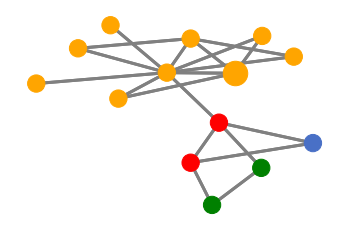

In [34]:
from dig.xgraph.method.subgraphx import PlotUtils
from dig.xgraph.method.subgraphx import MCTS
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data

subgraph_x, subgraph_edge_index, subset, edge_mask, kwargs = \
    MCTS.__subgraph__(node_idx, data.x, data.edge_index, num_hops=2)
subgraph_y = data.y[subset].to('cpu')
vis_graph = to_networkx(Data(x=subgraph_x, edge_index=subgraph_edge_index))
plotutils = PlotUtils(dataset_name='ba_shapes')
plotutils.plot(vis_graph, nodelist=[], figname=None, y=subgraph_y, node_idx=1)